## Project 4: Exploring the UK's milk imports and exports

by Tony Hirst and Michel Wermelinger, 19 November 2015, 28 March 2016, 18 October 2017, minor edit 20 December 2017  
'Improving trade relations with certain partners' and 'Regular exporters' by Llewellyn Deeprose-Morrison, 24 August 2020

This is the project notebook for Part 4 of The Open University's _Learn to Code for Data Analysis_ course.

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the UK's imports and exports of milk and cream in 2015:

- How much does the UK export and import and is the balance positive (more exports than imports)? 
- Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?
- Which are the regular customers, i.e. which countries buy milk from the UK every month?
- Which countries does the UK both import from and export to?

In [2]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

## Getting and preparing the data

The data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly 
- Periods: January to May of 2015
- Reporter: United Kingdom
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)

Clicking on 'Preview' results in a message that the data exceeds 500 rows. Data was downloaded using the *Download CSV* button and the download file renamed appropriately.

In [3]:
LOCATION = 'comtrade_milk_uk_jan_jul_15.csv'

The data can also be downloaded directly from Comtrade using the "View API Call" URL, modified in two ways:

- `max=500` is increased to `max=5000` to make sure all data is loaded,
- `&fmt=csv` is added at the end to obtain the data in CSV format.

In [4]:
# LOCATION = 'http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=201505%2C201504%2C201503%2C201502%2C201501&r=826&p=all&rg=1%2C2&cc=0401%2C0402&fmt=csv'

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero.

In [5]:
milk = read_csv(LOCATION, dtype={'Commodity Code':str})
milk.tail(2)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
635,HS,2015,201505,May 2015,4,0,2,Exports,826,United Kingdom,...,NaN,NaN,NaN,NaN,2213,NaN,37883,NaN,NaN,0
636,HS,2015,201505,May 2015,4,0,2,Exports,826,United Kingdom,...,NaN,NaN,NaN,NaN,1588,NaN,5676,NaN,NaN,0


The data only covers the first five months of 2015. Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [6]:
def milkType(code):
    if code == '0401': # neither concentrated nor sweetened
        return 'unprocessed'
    if code == '0402': # concentrated or sweetened
        return 'processed' 
    return 'unknown'

COMMODITY = 'Milk and cream'
milk[COMMODITY] = milk['Commodity Code'].apply(milkType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
milk = milk[headings]
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,201501,World,Imports,unprocessed,14104602
1,201501,World,Exports,unprocessed,26259792
2,201501,Australia,Exports,unprocessed,50331
3,201501,Austria,Exports,unprocessed,360
4,201501,Belgium,Imports,unprocessed,1424271


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [7]:
milk = milk[milk[PARTNER] != 'World']
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
2,201501,Australia,Exports,unprocessed,50331
3,201501,Austria,Exports,unprocessed,360
4,201501,Belgium,Imports,unprocessed,1424271
5,201501,Belgium,Exports,unprocessed,996031
6,201501,Bulgaria,Exports,unprocessed,191


## Total trade flow

To answer the first question, 'how much does the UK export and import and is the balance positive (more exports than imports)?',
the dataframe is split into two groups: exports from the UK and imports into the UK. The  trade values within each group are summed up to get the total trading.

In [8]:
grouped = milk.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports    265029661
Imports    156483978
Name: Trade Value (US$), dtype: int64

This shows a trade surplus of over 100 million dollars.

## Main trade partners

To address the second question, 'Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [9]:
imports = milk[milk[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('The UK imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to the UK are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

The UK imports from 21 countries.
The 5 biggest exporters to the UK are:


Partner
Ireland        46263897
France         28314091
Germany        21899123
Netherlands    17658912
Belgium        14325697
Name: Trade Value (US$), dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

<AxesSubplot:ylabel='Partner'>

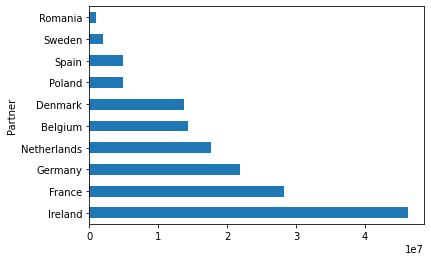

In [10]:
totalImports.head(10).plot(kind='barh')

In [11]:
exports = milk[milk[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('The UK exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the UK are:')
grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).head()

The UK exports to 107 countries.
The 5 biggest importers from the UK are:


Partner
Ireland                 128155891
Netherlands              18018603
China                    14111163
Germany                  10828464
China, Hong Kong SAR      9482458
Name: Trade Value (US$), dtype: int64

## Regular importers

Given that there are two commodities, the third question, 'Which are the regular customers, i.e. which countries buy milk from the UK every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [12]:
def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 201501) & (regular[COMMODITY] == 'processed')]

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
268,201501,Belgium,Exports,processed,142610
271,201501,China,Exports,processed,1013141
275,201501,Cyprus,Exports,processed,6625
280,201501,Denmark,Exports,processed,107883
284,201501,France,Exports,processed,178262
287,201501,Germany,Exports,processed,2588380
292,201501,"China, Hong Kong SAR",Exports,processed,1110086
294,201501,Hungary,Exports,processed,2119
298,201501,Ireland,Exports,processed,4020981
300,201501,Italy,Exports,processed,23267


Just over 75% of the total UK exports are due to these regular customers.

In [13]:
regular[VALUE].sum() / exports[VALUE].sum()

0.7583526396315317

### Improving trade relations with certain partners
Now that the regular importers have been identified, another question that naturally follows is: who are the any weaker partners? And are there weak importers with whom the UK could likely improve trade?

In [14]:
grouped[[VALUE]].aggregate(sum).mean()

Trade Value (US$)    2.476913e+06
dtype: float64

In [15]:
grouped[[VALUE]].aggregate(sum).median()

Trade Value (US$)    139740.0
dtype: float64

The mean trade value is \\$2.5 million whilst the median is much less at \\$140,000. This suggests a positive skew so there are a few partners who trade significantly more with the UK. Observing the average trade values can help to identify a threshold at which a partner can be said to be 'weak'. A graph would also be very useful.

<AxesSubplot:ylabel='Partner'>

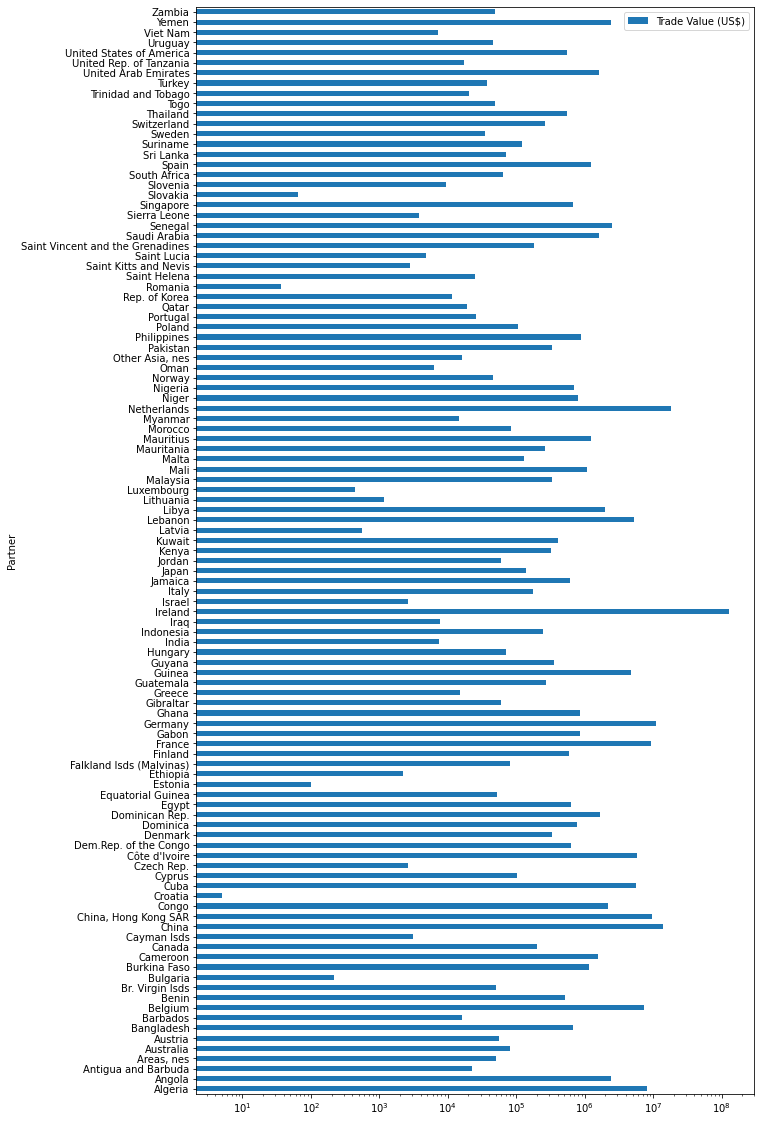

In [22]:
importersTotal = grouped[[VALUE]].aggregate(sum)
importersTotal.plot(logx=True, kind='barh', figsize=(10,20))

The above graph is rather crowded so it would be best to focus on only a certin group of countries. What about those who are import between \\$100,000 and \\$1,000,000? Trade with these partners could potentially be increased to break the million dollar line.

<AxesSubplot:ylabel='Partner'>

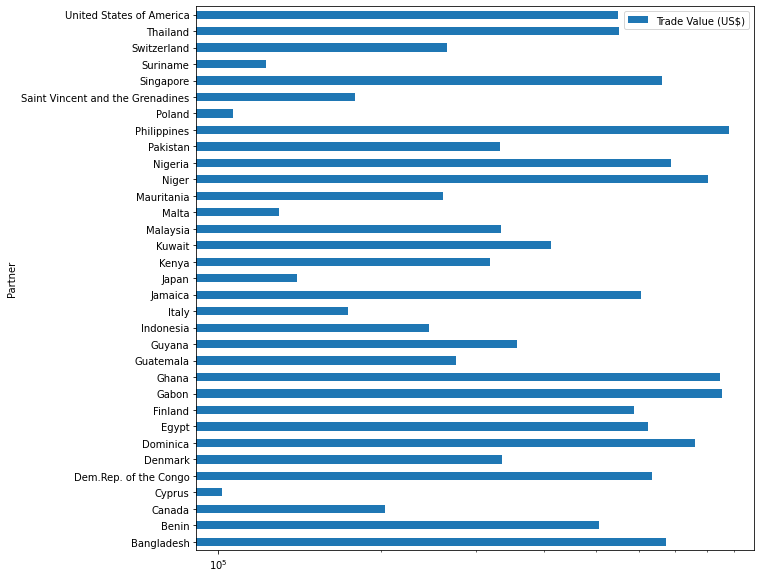

In [17]:
importersTotal[(importersTotal[VALUE] > 100000) & (importersTotal[VALUE] < 1000000)].plot(logx=True, kind='barh', figsize=(10,10))

This set of countries is still quite lenghty however it is not unmanageable. Therefore it may be worth considering improving trade relations with these countries.

## Regular exporters
How about the countries who regularly export milk products to the UK?

In [18]:
group2 = imports.groupby([PARTNER])
regImports = group2.filter(buysEveryMonth)
regImports[(regImports[MONTH] == 201501) & (regImports[COMMODITY] == "unprocessed")]

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
4,201501,Belgium,Imports,unprocessed,1424271
11,201501,Denmark,Imports,unprocessed,2546959
15,201501,France,Imports,unprocessed,1052140
17,201501,Germany,Imports,unprocessed,633626
22,201501,Ireland,Imports,unprocessed,6635455
24,201501,Italy,Imports,unprocessed,5896
27,201501,Lithuania,Imports,unprocessed,15649
30,201501,Netherlands,Imports,unprocessed,728391
32,201501,Poland,Imports,unprocessed,779394
34,201501,Portugal,Imports,unprocessed,27595


To see how much each country sells to the UK each month the following table will be created.

In [19]:
pivot_table(regImports.groupby([PARTNER, MONTH])[[VALUE]].aggregate(sum),
            index = [PARTNER],
            columns = [MONTH],
            values=VALUE,
            aggfunc=sum)
# Will not work with margins=True for some reason. Sas: ['Partner'] not in index.

Period,201501,201502,201503,201504,201505
Partner,,,,,
Belgium,3670490,2978909,3077519,2587489,2011290
Denmark,2641144,2617870,3396558,2515068,2511119
France,5667166,6016622,6406203,4799513,5424587
Germany,5191363,4206631,4967731,4094912,3438486
Ireland,9050515,7799161,6584201,11737887,11092133
Italy,156029,113873,20497,21884,9352
Lithuania,60209,57146,151368,22623,27061
Netherlands,4107746,3105834,4279405,2552629,3613298
Poland,1249988,1133413,992018,722491,836007


## Bi-directional trade

To address the fourth question, 
'Which countries does the UK both import from and export to?', a pivot table is used to list the total export and import value for each country. 

In [20]:
countries = pivot_table(milk, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum, margins=True)
countries.head()

Trade Flow,Exports,Imports,All
Partner,,,
Algeria,8087885.0,NaN,8087885
Angola,2416129.0,NaN,2416129
Antigua and Barbuda,22218.0,NaN,22218
"Areas, nes",51205.0,NaN,51205
Australia,81644.0,NaN,81644


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the UK.

In [21]:
countries.dropna()

Trade Flow,Exports,Imports,All
Partner,,,
Austria,56279.0,780.0,57059
Belgium,7209121.0,14325697.0,21534818
Czech Rep.,2590.0,486889.0,489479
Denmark,335068.0,13681759.0,14016827
France,9381762.0,28314091.0,37695853
Germany,10828464.0,21899123.0,32727587
Hungary,71378.0,4762.0,76140
Ireland,128155891.0,46263897.0,174419788
Italy,173689.0,321635.0,495324


## Conclusions

The milk and cream trade of the UK from January to May 2015 was analysed in terms of which countries the UK mostly depends on for income (exports) and goods (imports). Over the period, the UK had a trade surplus of over 100 million US dollars.

Ireland is the main partner, but it imported from the UK almost the triple in value than it exported to the UK. 

The UK exported to over 100 countries during the period, but only imported from 21 countries, the main ones (top five by trade value) being geographically close. China and Hong Kong are the main importers that are not also main exporters. 

The UK is heavily dependent on its regular customers, the 16 countries that buy all types of milk and cream every month. They contribute three quarters of the total export value.

The UK has bi-directional trade (i.e. both exports and imports) with 20 countries, although for some the trade value (in US dollars) is suspiciously low, which raises questions about the data's accuracy.